In [1]:
import torch
import torch.nn as nn
import pandas as pd
from flowprintOptimal.sekigo.modeling.neuralNetworks import LSTMNetwork,LinearPredictor,TransformerGenerator,CNNDiscriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from flowprintOptimal.sekigo.flowUtils.commons import loadFlows, saveFlows
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support
from flowprintOptimal.sekigo.dataAnalysis.vNATDataFrameProcessor import VNATDataFrameProcessor
from flowprintOptimal.sekigo.flowUtils.sampler import FixedLengthSampler
from flowprintOptimal.sekigo.flowUtils.flowDatasets import MaxNormalizedDataset,ActivityDataset,BaseFlowDataset,DDQNActivityDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.core import MemoryElement,Rewarder
from flowprintOptimal.sekigo.earlyClassification.DQL.datasets import MemoryDataset
from flowprintOptimal.sekigo.earlyClassification.DQL.trainers import EarlyClassificationtrainer
from flowprintOptimal.sekigo.earlyClassification.DQL.memoryFiller import MemoryFiller
from flowprintOptimal.sekigo.earlyClassification.DQL.core import State
from flowprintOptimal.sekigo.core.flowConfig import FlowConfig
from flowprintOptimal.sekigo.modeling.trainers import NNClassificationTrainer
from flowprintOptimal.sekigo.modeling.loggers import Logger
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import warnings
from flowprintOptimal.sekigo.dataAnalysis.dataFrameProcessor import SoftwareUpdateDataProcessor,GamingDownloadDataFrameProcessor
from flowprintOptimal.sekigo.dataAnalysis.dataFrameExtractor import DataFrameExtractor
warnings.filterwarnings('ignore')
from typing import List
from flowprintOptimal.sekigo.utils.commons import augmentData
import os


ImportError: cannot import name 'CNNDiscriminator' from 'flowprintOptimal.sekigo.modeling.neuralNetworks' (/home/captanlevi/Desktop/UNSW/flowprintOptimal/sekigo/modeling/neuralNetworks.py)

In [6]:
flow_config = FlowConfig(grain= 1, band_thresholds= [1250])
processor1 = SoftwareUpdateDataProcessor(parquet_path= "data/software-update-1w.parquet")
processor2 = GamingDownloadDataFrameProcessor(parquet_path= "data/2023-12-01--2023-12-31--flowprint.parquet")
flows = DataFrameExtractor.getData(data_frame_processors= [processor2,processor1],needed_flow_config= flow_config)

initial software update length = 72826
final software update length = 36790
after adding uploads size = 73580


In [24]:
def getGenerators(base_path,device):
    generators = []
    for generator_name in os.listdir(base_path):
        generator_path = os.path.join(base_path,generator_name)
        generator = TransformerGenerator(ts_dim= 4,random_dim= 16,embedding_dim= 64,num_heads= 4, num_layers= 5,device= device)
        generator.load(model_path= generator_path)
        generator.eval()
        generator.to(device= device)
        generators.append(generator)
    return generators

In [7]:
pd.Series(list(map(lambda x : x.class_type,flows))).value_counts()

Video           42230
Download        36761
Upload          36761
Conferencing    16769
Name: count, dtype: int64

In [3]:
"""
flows = loadFlows(path= "/Users/rushi/Desktop/UNSW/data/VNAT/flowStore/vnatflows1second.json")
class_type_filtered_flows = VNATDataFrameProcessor.convertLabelsToTopLevel(flows)
FT_filtered_flows = list(filter(lambda x : x.class_type != "FT",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "FT",class_type_filtered_flows))
len(FT_filtered_flows) + len(FT_flows) == len(class_type_filtered_flows)
"""

True

In [8]:
class_type_filtered_flows = flows
FT_filtered_flows = list(filter(lambda x : x.class_type != "Conferencing",class_type_filtered_flows))
FT_flows = list(filter(lambda x : x.class_type == "Conferencing",class_type_filtered_flows))

In [9]:
sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .01,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
FT_filtered_split_flows = sampler.sampleAndCutToLength(data= FT_filtered_flows)
ft_sampler = FixedLengthSampler(flow_config= FT_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .05,min_activity_for_start_point= 25,sample_wise_train_ratio= 1, temporal_train_ratio= 1)
FT_split_flows = ft_sampler.sampleAndCutToLength(data= FT_flows)
all_sampler = FixedLengthSampler(flow_config= class_type_filtered_flows[0].flow_config,required_length_in_seconds = 30,ratio_of_median_to_sample= .01,min_activity_for_start_point= 25,sample_wise_train_ratio= .8, temporal_train_ratio= 1)
all_flows = all_sampler.sampleAndCutToLength(data= class_type_filtered_flows)

{'Video': 0.008195859497708501, 'Download': 0.010022536113392067, 'Upload': 0.009999818986434214}
overlapping points = 0
{'Conferencing': 0.049998761662485805}
overlapping points = 0
{'Video': 0.009097623355554911, 'Conferencing': 0.02495073185747089, 'Download': 0.011125283279024218, 'Upload': 0.01110006666021314}
overlapping points = 0


In [10]:
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_filtered_split_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,all_flows["train_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,all_flows["test_flows"])).value_counts())
print(pd.Series(map(lambda x : x.class_type,FT_split_flows["train_flows"])).value_counts())

Video       29445
Download    28415
Upload      28255
Name: count, dtype: int64
Video       7265
Upload      7108
Download    6948
Name: count, dtype: int64
Download        32497
Video           29417
Upload          28215
Conferencing    18671
Name: count, dtype: int64
Download        7997
Video           7293
Upload          7148
Conferencing    4627
Name: count, dtype: int64
Conferencing    38027
Name: count, dtype: int64


In [11]:
all_train_dataset = DDQNActivityDataset(flows= all_flows["train_flows"],label_to_index= None)
all_test_dataset = DDQNActivityDataset(flows = all_flows["test_flows"], label_to_index= all_train_dataset.label_to_index)
train_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["train_flows"],label_to_index= None)
test_dataset = DDQNActivityDataset(flows= FT_filtered_split_flows["test_flows"],label_to_index= train_dataset.label_to_index)
ood_dataset = DDQNActivityDataset(flows= FT_split_flows["train_flows"],label_to_index= None)

In [25]:
generators : List[TransformerGenerator] = getGenerators(base_path = "models/generators",device= device)

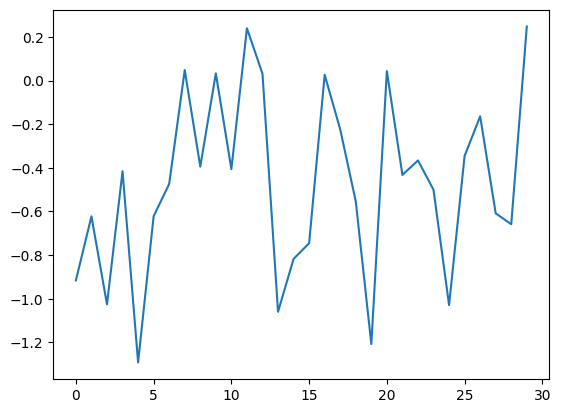

In [34]:
with torch.no_grad():
    generators[0].eval()
    gen = generators[0](torch.randn(1,30,16).to(device))[0].cpu().numpy()

plt.plot(gen[:,0])

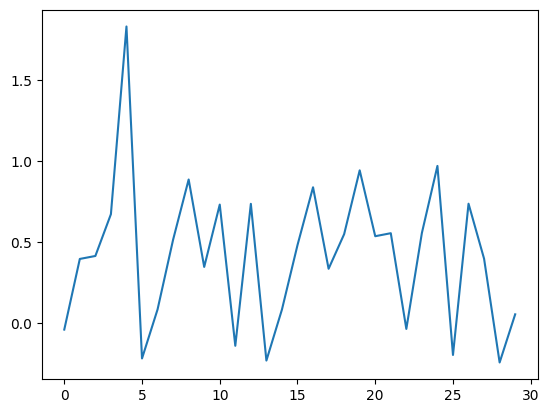

In [ ]:
feature_extractor = LSTMNetwork(lstm_hidden_size= 64,lstm_input_size=4,feature_dim= 64)
classifier = Predictor(feature_dim=64,num_classes= 3)

In [13]:
classification_trainer = NNClassificationTrainer(feature_extractor= feature_extractor,classifier= classifier,device= device,logger= Logger(name= "classification"))
classification_trainer.train(train_dataset= train_dataset,test_dataset= test_dataset,epochs= 30,batch_size= 64,lr= .0001)

classification ---- 1 metric test_f1 = 0.13158154140791123
classification ---- 1 metric train_f1 = 0.1294927459493805
classification ---- 10 metric train_loss = 1.113040018081665
classification ---- 20 metric train_loss = 1.1053889036178588
classification ---- 30 metric train_loss = 1.0984188675880433
classification ---- 40 metric train_loss = 1.0930214643478393
classification ---- 50 metric train_loss = 1.085642695426941
classification ---- 60 metric train_loss = 1.07919944524765
classification ---- 70 metric train_loss = 1.070660150051117
classification ---- 80 metric train_loss = 1.0655854940414429
classification ---- 90 metric train_loss = 1.054988169670105
classification ---- 100 metric train_loss = 1.0439714074134827
classification ---- 110 metric train_loss = 1.0271689176559449
classification ---- 120 metric train_loss = 1.0143385827541351
classification ---- 130 metric train_loss = 0.9763587057590485
classification ---- 140 metric train_loss = 0.9237328410148621
classification 

KeyboardInterrupt: 

In [13]:
class Rewarder:
    def __init__(self,max_length,l,num_labels : int):
        self.max_length = max_length
        self.l = l # l is smaller than 1
        self.num_labels = num_labels

    def reward(self,state : State,action : int):
        if state.label == action:
            # reward 1 on a correct prediction
            return 1, True
        else:
            # either incorrect or wait
            if state.length == self.max_length:
                # both get -1 if the length is max
                return -self.l, True
            
            # treat the wait action with a negative reward
            if action == self.num_labels:
                return -self.l*(state.length/self.max_length), False
            
            # reward -1 for incorrect answer.
            return -2,True

In [14]:
class MemoryFiller:
    def __init__(self,dataset : BaseFlowDataset,rewarder : Rewarder,min_length_in_seconds : int,
                 max_length_in_seconds,random_sample_inverse_ratio : int):
        self.dataset = dataset
        self.rewarder = rewarder

        grain = self.dataset.flow_config.grain
        self.min_length = int(min_length_in_seconds/grain)
        self.max_length = int(max_length_in_seconds/grain)

        self.actions = list(self.dataset.label_to_index.values())  
        self.random_sample_inverse_ratio = random_sample_inverse_ratio
        self.actions.append(len(self.actions))
    

        



    def processSingleSample(self,data):
        flow, label = data["data"], data["label"]
        memory_elements : List[MemoryElement] = []
        for length in range(self.min_length, self.max_length+1):
            for action in self.actions:
                state = State(timeseries= flow,label= label,length= length)
                reward, terminate = self.rewarder.reward(state= state,action= action)
                
                next_state = State(timeseries= flow,label= label,length= length + 1)
                if terminate == True:
                    # I am reducing the length as I will ahve to pass the state to LSTM 
                    # So I instead of filtering I will just zero all terminal states later.
                    next_state.length -= 1
                    next_state.setTerminal()
                
                memory_element = MemoryElement(state= state,action= action,reward= reward,next_state= next_state)
                memory_elements.append(memory_element)
        return memory_elements
    def processDataset(self):

        memory_elements = []
        
        for i in range(1,len(self.dataset)+1):
            # using 1 to len(dataset) + 1 so modulo does not throw an error
            if i%self.random_sample_inverse_ratio == 0:
                random_data_value = augmentData(self.dataset[i-1]["data"])
                random_data_label = -1
                data = dict(data = random_data_value,label = random_data_label)
                memory_elements.extend(self.processSingleSample(data))

            data = self.dataset[i-1]
            memory_elements.extend(self.processSingleSample(data))
 
        return memory_elements


In [15]:
rewarder = Rewarder(max_length= 30,l= .1,num_labels= len(train_dataset.label_to_index))
memory_filler = MemoryFiller(dataset= train_dataset,rewarder= rewarder, min_length_in_seconds= 5, max_length_in_seconds= 30,random_sample_inverse_ratio= 20)

In [16]:
memory = memory_filler.processDataset()

In [17]:
len(memory)

9384752

In [18]:
class RandomDataset(Dataset):
    def __init__(self,label_to_index) -> None:
        super().__init__()
        self.label_to_index = label_to_index

    def __getitem__(self, index):
        return {"data" : torch.rand(30,4), "label" : -1}


    def __len__(self):
        return 1000

In [19]:
memory_dataset = MemoryDataset(memories= memory,num_classes= len(train_dataset.label_to_index) + 1,min_length= memory_filler.min_length)
feature_extractor = LSTMFeatureExtractor(lstm_hidden_size= 64,lstm_input_size= 4,feature_dim= 64)
predictor = Predictor(feature_dim= 64,num_classes=  len(train_dataset.label_to_index) + 1)#Predictor(feature_dim= 64,num_classes= 4)
#random_dataset = RandomDataset(label_to_index= train_dataset.label_to_index)
logger = Logger(verbose= True)
logger.default_step_size = 500

In [20]:
ddq_model = EarlyClassificationtrainer(feature_extractor= feature_extractor, predictor= predictor,train_dataset = train_dataset,
                                       test_dataset= test_dataset,ood_dataset= ood_dataset ,memory_dataset= memory_dataset,
                                       logger= logger,device=device,model_replacement_steps= 100)

In [21]:
ddq_model.train(epochs= 50,batch_size= 64,model_lag_in_steps= 100,lr= .001)

 ---- 500 metric full_classifier_loss = 0.510468663573265
 ---- 500 metric loss = 0.5382102406024933
 ---- 1000 metric full_classifier_loss = 0.31185837811231615
 ---- 1000 metric loss = 0.4670039442032576
 ---- 1 metric test_eval_f1 = 0.9805069523293453
 ---- 1 metric test_eval_time = 20.01284019539428
 ---- 1 metric ood_eval = 0.625713308964683
 ---- 1500 metric full_classifier_loss = 0.19537525507807732
 ---- 1500 metric loss = 0.3734513407200575
 ---- 2000 metric full_classifier_loss = 0.14296490369737147
 ---- 2000 metric loss = 0.31690322047472
 ---- 2 metric test_eval_f1 = 0.9840052155753027
 ---- 2 metric test_eval_time = 14.307606420097697
 ---- 2 metric ood_eval = 0.9842743313961133
 ---- 1 metric train_eval_f1 = 0.9849395102627585
 ---- 1 metric train_eval_time = 14.215112693592115
 ---- 2500 metric full_classifier_loss = 0.12606665163859726
 ---- 2500 metric loss = 0.2960034559518099
 ---- 3000 metric full_classifier_loss = 0.11635273180902005
 ---- 3000 metric loss = 0.291

KeyboardInterrupt: 

In [88]:
ddq_model.evalTest(),ddq_model.evalOOD()

 ---- 54 metric test_eval_f1 = 0.9887560987676168
 ---- 54 metric test_eval_time = 13.246164574616458
 ---- 54 metric ood_eval = 0.3598495805611802


(None, None)

In [89]:
feature_extractor = ddq_model.feature_extractor

In [90]:
features,ood_features = [],[]
labels = []
loader = DataLoader(train_dataset,batch_size=64)
ood_loader = DataLoader(ood_dataset,batch_size= 32)

feature_extractor.eval()
predictor.eval()
with torch.no_grad():
    for batch in loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        labels.extend(batch_labels)
        features.extend(batch_out)

with torch.no_grad():
    for batch in ood_loader:
        batch_out = feature_extractor(batch["data"].float().to(device)).cpu().numpy().tolist()
        batch_labels = batch["label"].numpy().tolist()
        ood_features.extend(batch_out)


features = np.array(features)
ood_features = np.array(ood_features)
labels = np.array(labels)

In [93]:
features[labels == 1].std(axis = 0).max()

0.10480693005004879

In [50]:
np.linalg.norm(features[labels == 0].mean(axis = 0)),np.linalg.norm(ood_features.mean(axis= 0))

(1.5882271136813042, 1.8921774877602737)

NameError: name 'train_dataset' is not defined

In [51]:
train_dataset.label_to_index

{'Video': 0, 'Conferencing': 1, 'Upload': 2}

In [52]:
ood_dataset.label_to_index

{'Download': 0}

In [53]:
print(features[labels == 2].std(axis = 0).max())

0.16993044342149854


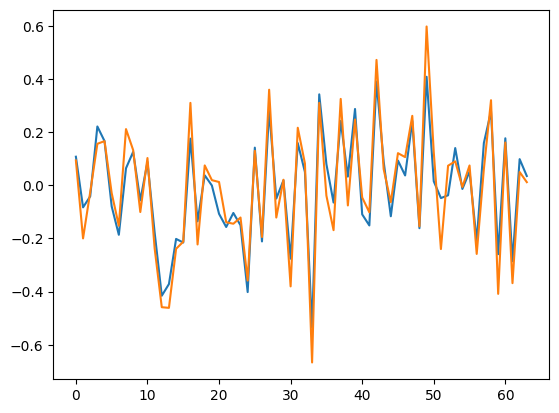

In [61]:
plt.plot(features[labels == 0].mean(axis = 0))
#plt.plot(features[labels == 1].mean(axis = 0))
#plt.plot(features[labels == 2].mean(axis = 0))
#plt.plot(features[labels == 3].mean(axis = 0))
plt.plot(ood_features.mean(axis= 0))
#with torch.no_grad():
#    plt.plot(feature_extractor(torch.rand(32,30,4).to(device)).cpu().numpy().mean(axis = 0))
#plt.plot(ood_features.mean(axis= 0)) 

In [116]:
predictions = ddq_model.predictOnDataset(dataset= RandomDataset(label_to_index= train_dataset.label_to_index))

In [117]:
timing = list(map(lambda x : x[1],predictions))
predictions = list(map(lambda x : x[0],predictions))
predictions = np.array(predictions)
timing = np.array(timing)
(predictions == -1).sum()/predictions.shape[0]

0.838

In [118]:
timing.mean()

26.687

: 